<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/lstm_ae_(2_layer)_UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
import tensorflow as tf
from tensorflow import keras

# Read Data

In [2]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def convert_label(row):
  if row["Classes"] == 'EI':
    return 0
  if row["Classes"] == 'IE':
    return 1
  if row["Classes"] == 'N':
    return 2

In [6]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/UCI/'
splice_df = pd.read_csv(data_path + 'splice.data', header=None)
splice_df.columns = ['Classes', 'Name', 'Seq']
splice_df["Seq"] = splice_df["Seq"].str.replace(' ', '').str.replace('N', 'A').str.replace('D', 'T').str.replace('S', 'C').str.replace('R', 'G')
splice_df["Label"] = splice_df.apply(lambda row: convert_label(row), axis=1)
print('The shape of the datasize is', splice_df.shape)
splice_df.head()

The shape of the datasize is (3190, 4)


,Classes,Name,Seq,Label
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,0
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,0
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,0
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,0
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,0


In [7]:
# check if the length of the sequence is the same 
seq_len = len(splice_df.Seq[0])
print("The length of the sequence is", seq_len)
for seq in splice_df.Seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 60


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(splice_df, splice_df.Label, test_size=0.2, random_state=100, stratify=splice_df.Label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (2041, 4) (511, 4) (638, 4) (2041,) (511,) (638,)


In [9]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
vocab_size = 4
print('vocab_size:', vocab_size)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [10]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [11]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T N') - 2

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3,  2,  1,  0, -1])>

In [12]:
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain['Seq']).map(index_preprocess).batch(32)
xval_seq = tf.data.Dataset.from_tensor_slices(xval['Seq']).map(index_preprocess).batch(32)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest['Seq']).map(index_preprocess).batch(32)

In [25]:
latent_size = 30
unit_size = 32

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, unit_size),
    keras.layers.Bidirectional(keras.layers.LSTM(unit_size, return_sequences=True)),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.LSTM(unit_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(4, activation='softmax'))  # ACTG
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 30)                29960     
_________________________________________________________________
sequential_5 (Sequential)    (None, 60, 4)             15516     
Total params: 45,476
Trainable params: 45,476
Non-trainable params: 0
_________________________________________________________________


In [26]:
recurrent_ae.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=500, callbacks=[es_cb])

Epoch 1/500
64/64 [==============================] - 3s 44ms/step - loss: 1.3575 - accuracy: 0.3201 - val_loss: 1.3411 - val_accuracy: 0.3520
Epoch 2/500
64/64 [==============================] - 1s 23ms/step - loss: 1.3334 - accuracy: 0.3569 - val_loss: 1.3290 - val_accuracy: 0.3612
Epoch 3/500
64/64 [==============================] - 1s 23ms/step - loss: 1.3230 - accuracy: 0.3643 - val_loss: 1.3229 - val_accuracy: 0.3664
Epoch 4/500
64/64 [==============================] - 1s 23ms/step - loss: 1.3147 - accuracy: 0.3733 - val_loss: 1.3120 - val_accuracy: 0.3762
Epoch 5/500
64/64 [==============================] - 1s 23ms/step - loss: 1.3078 - accuracy: 0.3784 - val_loss: 1.3083 - val_accuracy: 0.3802
Epoch 6/500
64/64 [==============================] - 2s 24ms/step - loss: 1.3040 - accuracy: 0.3811 - val_loss: 1.3052 - val_accuracy: 0.3839
Epoch 7/500
64/64 [==============================] - 1s 23ms/step - loss: 1.2995 - accuracy: 0.3840 - val_loss: 1.3005 - val_accuracy: 0.3867
Epoch 

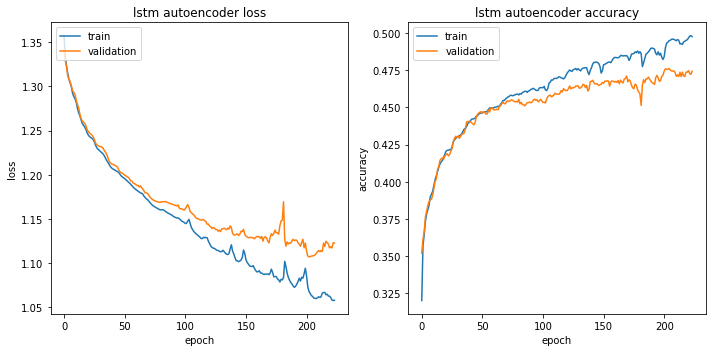

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [28]:
# how to reconstruct the sequence
idx_to_char = {'0':'T', '1':'G', '2':'C', '3':'A'}
def show_reconstructions(model, x_seq=xtrain_seq, original_data=xtrain, samples=10):
  reconstructions = recurrent_ae.predict(x_seq)
  print('The shape of reconstructions', reconstructions.shape)
  recon_softmax = np.argmax(reconstructions, axis=-1)
  for i in range(samples):
    seq = ''
    for idx in recon_softmax[i]:
      seq += idx_to_char[str(idx)]
    print()
    print('The {}-th original sequence vs after reconstruction'.format(i))
    print(original_data['Seq'].iloc[i])
    print(seq)

show_reconstructions(recurrent_ae, xval_seq, xval)

The shape of reconstructions (511, 60, 4)

The 0-th original sequence vs after reconstruction
AAGGGAGTGGCTTCCTCTCTGCCTCTGTGCCCACTGACATGTAGGGGAGAGGGGAAGATG
GGGGGGGGGGCTTTTTTTCCCCCCCCCCCCGGGGGGCCCTGGGGGAAAGGGGGGGGGGGG

The 1-th original sequence vs after reconstruction
GACACTGAGTAGGACCTCCAACTCTTACAGATCCCTTCCCCTGAAGTATTTGAAGAGCTG
GCCTTTGGGGAACCCAAAACCCCCCCCCAAGCCCCTTTTTCTGGGGGTTTTAAAAAGGGG

The 2-th original sequence vs after reconstruction
GATCTACTGTCTAATATCTTAAGGGCTTAGTATTTTTCTCAGTGACTTTGTGGGTTCTTT
TTTTTTTTTTTTTTTTTTTTCAAGAATTTTTTTTTTTTCAGGAAGTTTTTTTTTTTTTTT

The 3-th original sequence vs after reconstruction
AAAGCAGATCAGCTGTATAAACAGAAAATTATTCGTGGTTTCTGTCACTTGTGTGATGGT
AAAAGGTTTTTTTTTAAAAAAAAAAAAAATTTTTTTTTTTTTGGGTTTTTGGGGGGTTTT

The 4-th original sequence vs after reconstruction
AAGACCAGGTGGCTCCATGCCTTTCCCCAGGTTCTGGAGATGAGCATTGGGGCGCCGGAA
CCCCCAAGGGCCCCCCCCCCCCCCCCCCAGGCCCGGGGGGGGGGGGGGGGGGGGGGGGGA

The 5-th original sequence vs after reconstruction
ATGCTGACCACTTCCCTCTTCTCTGAGCAGTGTGAC

In [29]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (2041, 30) (511, 30) (638, 30)


In [18]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

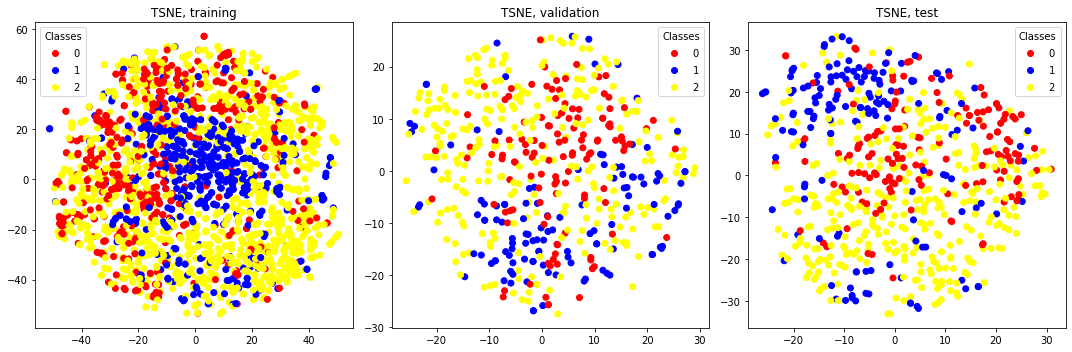

In [30]:
xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plotVec(axes[0], xtrain_tsne, ytrain, title="TSNE, training")
plotVec(axes[1], xval_tsne, yval, title="TSNE, validation")
plotVec(axes[2], xtest_tsne, ytest, title="TSNE, test")
fig.tight_layout()

In [34]:
model = keras.models.Sequential([

  keras.layers.Dense(64, activation="relu",input_shape=[latent_size]), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(32, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(3, activation="softmax")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [35]:
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=50, callbacks=[es_cb])

Epoch 1/50
64/64 [==============================] - 0s 5ms/step - loss: 1.0326 - accuracy: 0.5017 - val_loss: 0.9951 - val_accuracy: 0.5186
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9617 - accuracy: 0.5336 - val_loss: 0.9285 - val_accuracy: 0.5401
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9055 - accuracy: 0.5997 - val_loss: 0.8869 - val_accuracy: 0.6106
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 0.8662 - accuracy: 0.6218 - val_loss: 0.8382 - val_accuracy: 0.6223
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 0.8195 - accuracy: 0.6414 - val_loss: 0.7971 - val_accuracy: 0.6204
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.7901 - accuracy: 0.6497 - val_loss: 0.7557 - val_accuracy: 0.6536
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.7655 - accuracy: 0.6698 - val_loss: 0.7277 - val_accuracy: 0.6458
Epoch 8/50
64/64 [==

In [22]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [36]:
eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval, "Validation")
eval_model(model, xtest_vec, ytest, "Test")

Training Dataset: loss = 0.461 and acccuracy = 0.812
Validation Dataset: loss = 0.595 and acccuracy = 0.75
Test Dataset: loss = 0.535 and acccuracy = 0.784


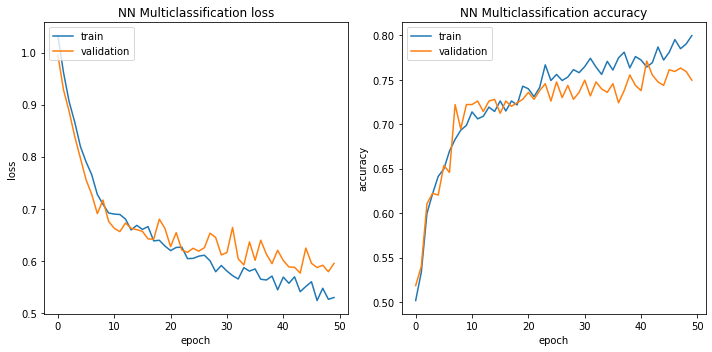

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()